# Notebook #1
## 1/ Ingesting and preparing PDF for LLM and Self Managed Vector Search Embeddings
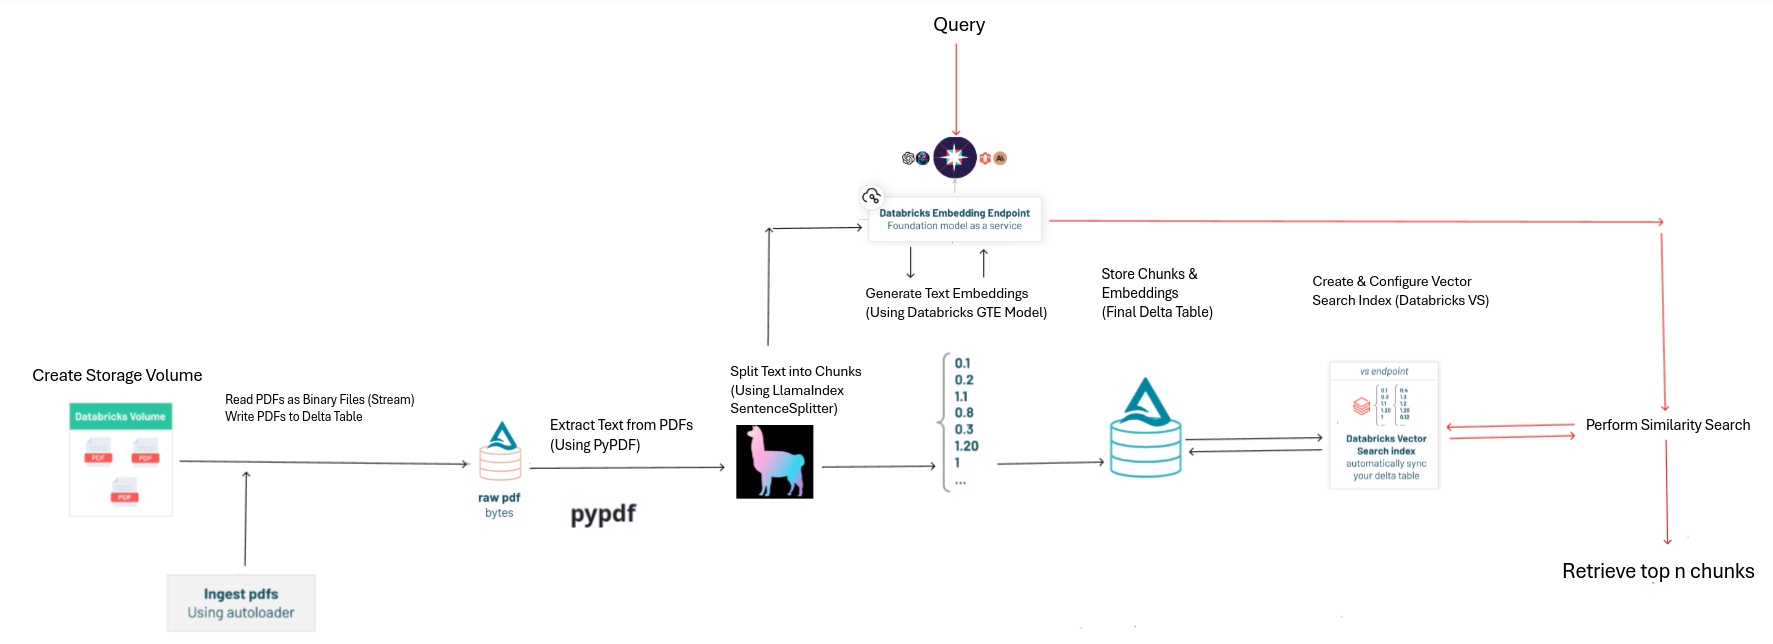

## In this example, we will focus on ingesting pdf documents as source for our retrieval process. 

<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/chatbot-rag/rag-pdf-self-managed-0.png?raw=true" style="float: right; width: 600px; margin-left: 10px">


For this example, we will add Databricks ebook PDFs from [Databricks resources page](https://www.databricks.com/resources) to our knowledge database.

**Note: This demo is advanced content, we strongly recommend going over the simple version first to learn the basics.**

Here are all the detailed steps:

- Use autoloader to load the binary PDFs into our first table. 
- Use the `unstructured` library  to parse the text content of the PDFs.
- Use `llama_index` or `Langchain` to split the texts into chuncks.
- Compute embeddings for the chunks.
- Save our text chunks + embeddings in a Delta Lake table, ready for Vector Search indexing.


Lakehouse AI not only provides state of the art solutions to accelerate your AI and LLM projects, but also to accelerate data ingestion and preparation at scale, including unstructured data like PDFs.

<div style="background-color: #d4f8d4; border-radius: 15px; padding: 20px; text-align: center;">
        Note: Looking for a full, production-grade guide? Make sure you checkout <a target="_blank" href="https://ai-cookbook.io">Databricks ai-cookbook.ai </a>!
    </div>

<!-- Collect usage data (view). Remove it to disable collection or disable tracker during installation. View README for more details.  -->
<img width="1px" src="https://ppxrzfxige.execute-api.us-west-2.amazonaws.com/v1/analytics?category=data-science&org_id=3324002747020755&notebook=%2F03-advanced-app%2F01-PDF-Advanced-Data-Preparation&demo_name=llm-rag-chatbot&event=VIEW&path=%2F_dbdemos%2Fdata-science%2Fllm-rag-chatbot%2F03-advanced-app%2F01-PDF-Advanced-Data-Preparation&version=1">

In [ ]:
%pip install -U transformers==4.41.1 pypdf==4.1.0 langchain-text-splitters==0.2.0 databricks-vectorsearch mlflow==2.20.0 tiktoken==0.7.0 torch==2.3.0 llama-index==0.10.43
dbutils.library.restartPython()

INFO: pip is looking at multiple versions of llama-index-llms-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of llama-index-program-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of llama-parse to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of llama-parse to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.

*** WARNING: max output size exceeded, skipping output. ***

32m56.4/56.5 MB 217.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%run ../_resources/00-init-advanced $reset_all_data=false

USE CATALOG `main`
using catalog.database `main`.`dbdemos_rag_chatbot`


DataFrame[]

## Ingesting Databricks ebook PDFs and extracting their pages

<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/chatbot-rag/rag-pdf-self-managed-1.png?raw=true" style="float: right" width="500px">

First, let's ingest our PDFs as a Delta Lake table with path urls and content in binary format. 

We'll use [Databricks Autoloader](https://docs.databricks.com/en/ingestion/auto-loader/index.html) to incrementally ingeset new files, making it easy to incrementally consume billions of files from the data lake in various data formats. Autoloader easily ingests our unstructured PDF data in binary format.


In [ ]:
%sql
CREATE VOLUME IF NOT EXISTS volume_databricks_documentation;

In [ ]:
# List our raw PDF docs
volume_folder =  f"/Volumes/{catalog}/{db}/volume_databricks_documentation"
# Let's upload some pdf files to our volume as example. Change this with your own PDFs / docs.
upload_pdfs_to_volume(volume_folder+"/databricks-pdf")

display(dbutils.fs.ls(volume_folder+"/databricks-pdf"))

saving /Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/LP_2-primary-asset_standardizing-the-ml-lifecycle-ebook-databricks-0626120-v8.pdf
saving /Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/Databricks_eBook_FinServ_Personalization-FINAL-092622_image.pdf
saving /Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/EB-Ingesting-Data-FINAL.pdf
saving /Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/8-steps-to-becoming-a-ai-forward-retailer-ebook.pdf
saving /Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/Data-AI-in-Fed-Gov-Ebook.pdf
saving /Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/Lakehouse-for-Manufacturing.pdf
saving /Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/The-Delta-Lake-Series-Lakehouse-012921.pdf
saving /Volumes/main/dbdemos_rag_chatbot/volume_databr

path,name,size,modificationTime
dbfs:/Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/030521-2-The-Delta-Lake-Series-Complete-Collection.pdf,030521-2-The-Delta-Lake-Series-Complete-Collection.pdf,4876146,1738660259000
dbfs:/Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/8-steps-to-becoming-a-ai-forward-retailer-ebook.pdf,8-steps-to-becoming-a-ai-forward-retailer-ebook.pdf,1613150,1738660259000
dbfs:/Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/Data-AI-in-Fed-Gov-Ebook.pdf,Data-AI-in-Fed-Gov-Ebook.pdf,5002642,1738660259000
dbfs:/Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/Databricks-Customer-360-ebook-Final.pdf,Databricks-Customer-360-ebook-Final.pdf,2407624,1738660259000
dbfs:/Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/Databricks_eBook_FinServ_Personalization-FINAL-092622_image.pdf,Databricks_eBook_FinServ_Personalization-FINAL-092622_image.pdf,1968304,1738660259000
dbfs:/Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/EB-Ingesting-Data-FINAL.pdf,EB-Ingesting-Data-FINAL.pdf,1008287,1738660258000
dbfs:/Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/LP_2-primary-asset_standardizing-the-ml-lifecycle-ebook-databricks-0626120-v8.pdf,LP_2-primary-asset_standardizing-the-ml-lifecycle-ebook-databricks-0626120-v8.pdf,8514297,1738660259000
dbfs:/Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/Lakehouse-for-Manufacturing.pdf,Lakehouse-for-Manufacturing.pdf,3808999,1738660259000
dbfs:/Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/The-Data-Teams-Guide-to-the-DB-Lakehouse-Platform.pdf,The-Data-Teams-Guide-to-the-DB-Lakehouse-Platform.pdf,22087071,1738660259000
dbfs:/Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/The-Delta-Lake-Series-Lakehouse-012921.pdf,The-Delta-Lake-Series-Lakehouse-012921.pdf,869035,1738660259000


In [ ]:
df = (spark.readStream
        .format('cloudFiles')
        .option('cloudFiles.format', 'BINARYFILE')
        .option("pathGlobFilter", "*.pdf")
        .load('dbfs:'+volume_folder+"/databricks-pdf"))

# Write the data as a Delta table
(df.writeStream
  .trigger(availableNow=True)
  .option("checkpointLocation", f'dbfs:{volume_folder}/checkpoints/raw_docs')
  .table('pdf_raw').awaitTermination())

In [ ]:
%sql SELECT * FROM pdf_raw LIMIT 2

path,modificationTime,length,content


<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/chatbot-rag/rag-pdf-self-managed-2.png?raw=true" style="float: right" width="500px">

## Extracting our PDF content as text chunks

We need to convert the PDF documents bytes to text, and extract chunks from their content.

This part can be tricky as PDFs are hard to work with and can be saved as images, for which we'll need an OCR to extract the text.

Using the `Unstructured` library within a Spark UDF makes it easy to extract text. 

*Note: Your cluster will need a few extra libraries that you would typically install with a cluster init script.*

<br style="clear: both">

### Splitting our big documentation page in smaller chunks

<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/chatbot-rag/chunk-window-size.png?raw=true" style="float: right" width="700px">

In this demo, some PDFs are very large, with a lot of text.

We'll extract the content and then use llama_index `SentenceSplitter`, and ensure that each chunk isn't bigger than 500 tokens. 


The chunk size and chunk overlap depend on the use case and the PDF files. 

Remember that your prompt+answer should stay below your model max window size (4096 for llama2). 

For more details, review the previous [../01-Data-Preparation](01-Data-Preparation) notebook. 

<br/>
<br style="clear: both">
<div style="background-color: #def2ff; padding: 15px;  border-radius: 30px; ">
  <strong>Information</strong><br/>
  Remember that the following steps are specific to your dataset. This is a critical part to building a successful RAG assistant.
  <br/> Always take time to review the chunks created and ensure they make sense and contain relevant information.
</div>

In [ ]:
import warnings
from pypdf import PdfReader

def parse_bytes_pypdf(raw_doc_contents_bytes: bytes):
    #Note: in production setting you might want to try/catch errors here to handle incorrect pdf/files
    pdf = io.BytesIO(raw_doc_contents_bytes)
    reader = PdfReader(pdf)
    parsed_content = [page_content.extract_text() for page_content in reader.pages]
    return "\n".join(parsed_content)

Let's start by extracting text from our PDF.

In [ ]:
import io
import re
with requests.get('https://dbdemos-dataset.s3.amazonaws.com/llm/databricks-pdf-documentation/Databricks-Customer-360-ebook-Final.pdf') as pdf:
  doc = parse_bytes_pypdf(pdf.content)  
  print(doc)

6 Strategies for Building 
Personalized Customer 
ExperiencesGuide

Contents
Introduction .......................................................................................................................................................................... .......................................  3
 1.   Building a Foundation for Personalization  
Leveraging ML-Based Customer Entity Resolution  ..............................................................................................................................  4
2.  Estimating Customer Lifetime Value  
Building Brand Loyalty With Data  .................................................................................................................................................................  6
3.  Mitigating Customer Churn 
Balancing Acquisition and Retention  ......................................................................................................................................................... 10 
4.

This looks great. We'll now wrap it with a text_splitter to avoid having too big pages, and create a Pandas UDF function to easily scale that across multiple nodes.

*Note that our pdf text isn't clean. To make it nicer, we could use a few extra LLM-based pre-processing steps, asking to remove unrelevant content like the list of chapters and to only keep the core text.*

In [ ]:
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Document, set_global_tokenizer
from transformers import AutoTokenizer
from typing import Iterator

# Reduce the arrow batch size as our PDF can be big in memory (classic compute only)
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", 10)

@pandas_udf("array<string>")
def read_as_chunk(batch_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
    #set llama2 as tokenizer to match our model size (will stay below gte 1024 limit)
    set_global_tokenizer(
      AutoTokenizer.from_pretrained("hf-internal-testing/llama-tokenizer", cache_dir="/tmp/hf_cache")
    )
    #Sentence splitter from llama_index to split on sentences
    splitter = SentenceSplitter(chunk_size=500, chunk_overlap=10)
    def extract_and_split(b):
      try:
        txt = parse_bytes_pypdf(b)
      except Exception as e:
        txt = f'__PDF_PARSING_ERROR__ file: {e}'
        print(txt)
      if txt is None:
        return []
      nodes = splitter.get_nodes_from_documents([Document(text=txt)])
      return [n.text for n in nodes]

    for x in batch_iter:
        yield x.apply(extract_and_split)

## What's required for our Vector Search Index

<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/chatbot-rag/databricks-vector-search-type.png?raw=true" style="float: right" width="800px">

Databricks provide multiple types of vector search indexes:

- **Managed embeddings**: you provide a text column and endpoint name and Databricks synchronizes the index with your Delta table 
- **Self Managed embeddings**: you compute the embeddings and save them as a field of your Delta Table, Databricks will then synchronize the index
- **Direct index**: when you want to use and update the index without having a Delta Table.

In this demo, we will show you how to setup a **Self-managed Embeddings** index. 

To do so, we will have to first compute the embeddings of our chunks and save them as a Delta Lake table field as `array&ltfloat&gt`

## Introducing Databricks GTE Embeddings Foundation Model endpoints

<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/chatbot-rag/rag-pdf-self-managed-4.png?raw=true" style="float: right; width: 600px; margin-left: 10px">

Foundation Models are provided by Databricks, and can be used out-of-the-box.

Databricks supports several endpoint types to compute embeddings or evaluate a model:
- DBRX Instruct, a **foundation model endpoint**, or another model served by databricks (ex: llama2-70B, MPT...)
- An **external endpoint**, acting as a gateway to an external model (ex: Azure OpenAI)
- A **custom**, fined-tuned model hosted on Databricks model service

Open the [Model Serving Endpoint page](/ml/endpoints) to explore and try the foundation models.

For this demo, we will use the foundation model `GTE` (embeddings) and `DBRX` (chat). <br/><br/>

<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/chatbot-rag/databricks-foundation-models.png?raw=true" width="600px" >

In [ ]:
from mlflow.deployments import get_deploy_client

# gte-large-en Foundation models are available using the /serving-endpoints/databricks-gtegte-large-en/invocations api. 
deploy_client = get_deploy_client("databricks")

## NOTE: if you change your embedding model here, make sure you change it in the query step too
embeddings = deploy_client.predict(endpoint="databricks-gte-large-en", inputs={"input": ["What is Apache Spark?"]})
pprint(embeddings)

{'data': [{'embedding': [1.044921875, -0.05377197265625, -0.281005859375, -0.09075927734375,
                         0.0960693359375, -0.1328125, 0.15869140625, 0.281982421875, 0.76123046875,
                         0.416015625, 0.6064453125, -0.0606689453125, 0.104736328125, 0.59033203125,
                         -0.40087890625, 0.355712890625, 0.58837890625, 0.433349609375,
                         0.06109619140625, -0.2039794921875, -0.59326171875, 0.099365234375,
                         -0.334716796875, -2.966796875, 0.303466796875, 0.423095703125,
                         0.0034503936767578125, -0.0914306640625, -0.85009765625, 0.032684326171875,
                         0.489501953125, 0.00685882568359375, -1.4111328125, 0.418212890625,
                         0.634765625, -0.272705078125, -0.34130859375, 1.3095703125,
                         -0.281005859375, -0.716796875, -0.2232666015625, -0.1219482421875,
                         -0.7705078125, 0.09332275390625, 1.385742

In [ ]:
%sql
--Note that we need to enable Change Data Feed on the table to create the index
CREATE TABLE IF NOT EXISTS databricks_pdf_documentation (
  id BIGINT GENERATED BY DEFAULT AS IDENTITY,
  url STRING,
  content STRING,
  embedding ARRAY <FLOAT>
) TBLPROPERTIES (delta.enableChangeDataFeed = true); 

### Computing the chunk embeddings and saving them to our Delta Table

The last step is to now compute an embedding for all our documentation chunks. Let's create an udf to compute the embeddings using the foundation model endpoint.

*Note that this part would typically be setup as a production-grade job, running as soon as a new documentation page is updated. <br/> This could be setup as a Delta Live Table pipeline to incrementally consume updates.*

In [ ]:
@pandas_udf("array<float>")
def get_embedding(contents: pd.Series) -> pd.Series:
    import mlflow.deployments
    deploy_client = mlflow.deployments.get_deploy_client("databricks")
    def get_embeddings(batch):
        #Note: this will fail if an exception is thrown during embedding creation (add try/except if needed) 
        response = deploy_client.predict(endpoint="databricks-gte-large-en", inputs={"input": batch})
        return [e['embedding'] for e in response.data]

    # Splitting the contents into batches of 150 items each, since the embedding model takes at most 150 inputs per request.
    max_batch_size = 150
    batches = [contents.iloc[i:i + max_batch_size] for i in range(0, len(contents), max_batch_size)]

    # Process each batch and collect the results
    all_embeddings = []
    for batch in batches:
        all_embeddings += get_embeddings(batch.tolist())

    return pd.Series(all_embeddings)

In [ ]:
(spark.readStream.table('pdf_raw')
      .withColumn("content", F.explode(read_as_chunk("content")))
      .filter("content not like '__PDF_PARSING_ERROR__%'") #Drop PDF with parsing ERROR (could throw an error instead or properly flag that in a prod setup to avoid silent failures)
      .withColumn("embedding", get_embedding("content"))
      .selectExpr('path as url', 'content', 'embedding')
  .writeStream
    .trigger(availableNow=True)
    .option("checkpointLocation", f'dbfs:{volume_folder}/checkpoints/pdf_chunk')
    .table('databricks_pdf_documentation').awaitTermination())

#Let's also add our documentation web page from the simple demo (make sure you run the quickstart demo first)
if spark.catalog.tableExists(f'{catalog}.{db}.databricks_documentation'):
  (spark.readStream.option("skipChangeCommits", "true").table('databricks_documentation') #skip changes for more stable demo
      .withColumn('embedding', get_embedding("content"))
      .select('url', 'content', 'embedding')
  .writeStream
    .trigger(availableNow=True)
    .option("checkpointLocation", f'dbfs:{volume_folder}/checkpoints/docs_chunks')
    .table('databricks_pdf_documentation').awaitTermination())

Query ac1a66a4-3434-412c-a482-4b1d264dbc09 has not received any updates in 60 seconds. Spark Session ID is fb97c5a8-0862-44bd-ba4c-27f3097d5b1d
Query ac1a66a4-3434-412c-a482-4b1d264dbc09 has not received any updates in 60 seconds. Spark Session ID is fb97c5a8-0862-44bd-ba4c-27f3097d5b1d
Query ac1a66a4-3434-412c-a482-4b1d264dbc09 has not received any updates in 60 seconds. Spark Session ID is fb97c5a8-0862-44bd-ba4c-27f3097d5b1d
Query ac1a66a4-3434-412c-a482-4b1d264dbc09 has not received any updates in 60 seconds. Spark Session ID is fb97c5a8-0862-44bd-ba4c-27f3097d5b1d
Query ac1a66a4-3434-412c-a482-4b1d264dbc09 has not received any updates in 60 seconds. Spark Session ID is fb97c5a8-0862-44bd-ba4c-27f3097d5b1d
Query ac1a66a4-3434-412c-a482-4b1d264dbc09 has not received any updates in 60 seconds. Spark Session ID is fb97c5a8-0862-44bd-ba4c-27f3097d5b1d
Query ac1a66a4-3434-412c-a482-4b1d264dbc09 has not received any updates in 60 seconds. Spark Session ID is fb97c5a8-0862-44bd-ba4c-27f30

In [ ]:
%sql
SELECT * FROM databricks_pdf_documentation WHERE url like '%.pdf' limit 10

id url content embedding 1 dbfs:/Volumes/main/dbdemos_rag_chatbot/volume_databricks_documentation/databricks-pdf/technical_guide_solving_common-data-challenges-for-startups-and-digital-native-businesses.pdf Solving Common 
Data Challenges TECHNICAL GUIDE 
Startups and Digital 
Native Businesses

Table of Contents
01 CHALLENGE: 
 
Creating a unified 
data architecture 
for data quality, 
governance and 
efficiency02 CHALLENGE: 
 
Building a data 
architecture to 
support scale and 
performance
03 CHALLENGE: 
 
Building effective 
machine learning 
operations04 SUMMARY: 
 
The Databricks 
Lakehouse Platform 
addresses these 
challenges
`2
`This guide shares how the lakehouse architecture can increase 
productivity and cost-efficiently support all your data, analytics 
and AI workloads, and flexibly scale with the pace of growth 
for your company. Read the entire guide or dive straight into a 
specific challenge. 
With the advent of cloud infrastructure, a new generation of 
startups has rapidly built and scaled their businesses. The use of 
cloud infrastructure, once seen as innovative, has now become 
table stakes. The differentiator for the fastest-moving startups 
and digital natives now comes from the effective use of data 
at scale, primarily analytics and AI. Digital natives — defined 
as fast-moving, lean, and technically savvy, born-in-the-cloud 
organizations — are beginning to focus on new data-driven use 
cases such as real-time machine learning and personalized 
customer experiences. 
To pursue these new data-intensive use cases and initiatives, 
organizations must look beyond the technologies that delivered 
them to this point in time. List(-0.86328125, 0.20324707, -0.16467285, 0.7036133, -0.049072266, 0.39331055, -0.33666992, -0.57714844, 0.03375244, 0.45751953, -0.24633789, -0.6586914, -0.52783203, 0.71875, 0.34423828, 0.16601562, -0.35009766, 0.90722656, -0.64404297, 0.011352539, -0.38989258, -1.8505859, 0.2163086, -2.7167969, 0.5756836, 0.15002441, 0.5600586, -1.2822266, -0.27075195, 0.20397949, 0.25585938, 1.0117188, -1.3828125, 0.55566406, 0.3918457, -0.17797852, -0.2211914, -0.21704102, -0.81884766, -0.1661377, -0.66552734, -0.5214844, 0.037384033, -0.5078125, 0.13183594, 0.90478516, 0.7988281, -0.51123047, 0.06384277, -0.81347656, -0.67578125, 0.9897461, 0.9399414, 0.28125, -0.38867188, -0.1685791, 0.3005371, 0.8232422, 0.38867188, -0.6738281, 0.06591797, 0.99121094, -0.5932617, -0.42578125, 0.73339844, 0.023590088, -0.28173828, 1.0478516, -0.82910156, 0.68359375, 0.32739258, 0.3449707, 0.47729492, 0.28027344, -0.1940918, 0.50634766, -0.42797852, 0.7714844, 0.8173828, 0.5908203, 0.009101868, 0.4633789, 0.54003906, 0.48120117, -0.46435547, 0.7758789, 0.66015625, -0.5859375, 0.28076172, 1.9169922, -0.19250488, -0.38793945, -0.8652344, 0.122680664, 0.40673828, -0.26245117, -0.47607422, -0.09020996, -0.045074463, -0.17834473, 0.17248535, 0.4645996, 0.90722656, -0.04840088, -0.38916016, -0.5708008, -0.33374023, -0.75341797, 0.48364258, 0.33496094, -0.91259766, 0.07342529, 0.097839355, -0.13757324, 0.29003906, -0.11529541, 0.06854248, -0.7363281, 0.4465332, -0.08270264, 0.46264648, 0.1685791, 0.5102539, 0.45532227, -0.21508789, 0.26123047, 0.7290039, 0.9223633, -0.5751953, 0.45898438, 0.4555664, -0.28100586, -0.044036865, -0.40234375, -0.7709961, -0.08746338, -1.4316406, 0.67333984, -0.05419922, -0.6479492, 0.12817383, 0.42236328, -0.4440918, -0.35083008, 0.41186523, 0.28466797, 0.6586914, -0.1104126, -0.17260742, -0.8339844, -0.77001953, -0.171875, 0.4819336, 0.02053833, -0.3684082, 1.0380859, -0.5097656, -0.62646484, -0.56396484, -0.3918457, -0.104003906, -1.1601562, -1.4082031, 0.24645996, -0.4736328, -0.07269287, 0.02772522, 0.5625, -0.091674805, 0.33496094, -0.48999023, 0.091674805, 0.09887695, -1.9570312, 0.3076172, -0.21911621, 0.13183594, -1.328125, -0.21765137, -0.7817383, -0.39379883, -1.0439453, -0.17102051, -0.66796875, -1.1455078, -0.15698242, -0.025100708, 0.22192383, -0.47021484, -0.35864258, -0.044


### Our dataset is now ready! Let's create our Self-Managed Vector Search Index.

<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/chatbot-rag/rag-pdf-self-managed-3.png?raw=true" style="float: right; width: 600px; margin-left: 10px">

Our dataset is now ready. We chunked the documentation pages into small sections, computed the embeddings and saved it as a Delta Lake table.

Next, we'll configure Databricks Vector Search to ingest data from this table.

Vector search index uses a Vector search endpoint to serve the embeddings (you can think about it as your Vector Search API endpoint). <br/>
Multiple Indexes can use the same endpoint. Let's start by creating one.

In [ ]:
from databricks.vector_search.client import VectorSearchClient
vsc = VectorSearchClient()

if not endpoint_exists(vsc, VECTOR_SEARCH_ENDPOINT_NAME):
    vsc.create_endpoint(name=VECTOR_SEARCH_ENDPOINT_NAME, endpoint_type="STANDARD")

wait_for_vs_endpoint_to_be_ready(vsc, VECTOR_SEARCH_ENDPOINT_NAME)
print(f"Endpoint named {VECTOR_SEARCH_ENDPOINT_NAME} is ready.")

[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True to VectorSearchClient().
Waiting for endpoint to be ready, this can take a few min... {'name': 'dbdemos_vs_endpoint', 'creator': 'vinothks.123@gmail.com', 'creation_timestamp': 1738661065222, 'last_updated_timestamp': 1738661065222, 'endpoint_type': 'STANDARD', 'last_updated_user': 'vinothks.123@gmail.com', 'id': '0d86d77c-3680-4489-9503-93658d78fd14', 'endpoint_status': {'state': 'PROVISIONING'}, 'num_indexes': 0}
Waiting for endpoint to be ready, this can take a few min... {'name': 'dbdemos_vs_endpoint', 'creator': 'vinothks.123@gmail.com', 'creation_timestamp': 1738661065222, 'last_updated_timestamp': 1738661065222, 'endpoint_type': 'STANDARD', 'last_updated_user': 'vinothks.123@gmail.com', 'id': '0d86d77c-3680-4489-9503-93658d78fd14', 'endpoint_status': {'state': 'PROVISIONING


You can view your endpoint on the [Vector Search Endpoints UI](#/setting/clusters/vector-search). Click on the endpoint name to see all indexes that are served by the endpoint.

In [ ]:
from databricks.sdk import WorkspaceClient
import databricks.sdk.service.catalog as c

#The table we'd like to index
source_table_fullname = f"{catalog}.{db}.databricks_pdf_documentation"
# Where we want to store our index
vs_index_fullname = f"{catalog}.{db}.databricks_pdf_documentation_self_managed_vs_index"

if not index_exists(vsc, VECTOR_SEARCH_ENDPOINT_NAME, vs_index_fullname):
  print(f"Creating index {vs_index_fullname} on endpoint {VECTOR_SEARCH_ENDPOINT_NAME}...")
  try:
    vsc.create_delta_sync_index(
      endpoint_name=VECTOR_SEARCH_ENDPOINT_NAME,
      index_name=vs_index_fullname,
      source_table_name=source_table_fullname,
      pipeline_type="TRIGGERED", #Sync needs to be manually triggered
      primary_key="id",
      embedding_dimension=1024, #Match your model embedding size (gte)
      embedding_vector_column="embedding"
    )
  except Exception as e:
    display_quota_error(e, VECTOR_SEARCH_ENDPOINT_NAME)
    raise e
  #Let's wait for the index to be ready and all our embeddings to be created and indexed
  wait_for_index_to_be_ready(vsc, VECTOR_SEARCH_ENDPOINT_NAME, vs_index_fullname)
else:
  #Trigger a sync to update our vs content with the new data saved in the table
  wait_for_index_to_be_ready(vsc, VECTOR_SEARCH_ENDPOINT_NAME, vs_index_fullname)
  vsc.get_index(VECTOR_SEARCH_ENDPOINT_NAME, vs_index_fullname).sync()

Creating index main.dbdemos_rag_chatbot.databricks_pdf_documentation_self_managed_vs_index on endpoint dbdemos_vs_endpoint...
Waiting for index to be ready, this can take a few min... {'detailed_state': 'PROVISIONING_INDEX', 'message': 'Delta sync Index creation is pending. Check latest status: https://dbc-e8d4ab77-d994.cloud.databricks.com/explore/data/main/dbdemos_rag_chatbot/databricks_pdf_documentation_self_managed_vs_index', 'indexed_row_count': 0, 'ready': False, 'index_url': 'dbc-e8d4ab77-d994.cloud.databricks.com/api/2.0/vector-search/endpoints/dbdemos_vs_endpoint/indexes/main.dbdemos_rag_chatbot.databricks_pdf_documentation_self_managed_vs_index'} - pipeline url:dbc-e8d4ab77-d994.cloud.databricks.com/api/2.0/vector-search/endpoints/dbdemos_vs_endpoint/indexes/main.dbdemos_rag_chatbot.databricks_pdf_documentation_self_managed_vs_index


## Searching for similar content

That's all we have to do. Databricks will automatically capture and synchronize new entries in your Delta Lake Table.

Note that depending on your dataset size and model size, index creation can take a few seconds to start and index your embeddings.

Let's give it a try and search for similar content.

*Note: `similarity_search` also supports a filters parameter. This is useful to add a security layer to your RAG system: you can filter out some sensitive content based on who is doing the call (for example filter on a specific department based on the user preference).*

In [ ]:
question = "How to get familiar with Gen AI developmenet in Databricks?"

response = deploy_client.predict(endpoint="databricks-gte-large-en", inputs={"input": [question]})
embeddings = [e['embedding'] for e in response.data]

results = vsc.get_index(VECTOR_SEARCH_ENDPOINT_NAME, vs_index_fullname).similarity_search(
  query_vector=embeddings[0],
  columns=["url", "content"],
  num_results=1)
docs = results.get('result', {}).get('data_array', [])
pprint(docs)

[['https://docs.databricks.com/en/machine-learning/index.html',
  'AI and Machine Learning on Databricks  \n'
  'This article describes the tools that Databricks provides to help you build and monitor AI and '
  'ML workflows. The diagram shows how these components work together to help you implement your '
  'model development and deployment process.  \n'
  'Why use Databricks for machine learning and deep learning?\n'
  'Why use Databricks for machine learning and deep learning?\n'
  'With Databricks, you can implement the full ML lifecycle on a single platform with end-to-end '
  'governance throughout the ML pipeline. Databricks includes the following built-in tools to '
  'support ML workflows:  \n'
  'Unity Catalog for governance, discovery, versioning, and access control for data, features, '
  'models, and functions.  \n'
  'Lakehouse Monitoring for data monitoring.  \n'
  'Feature engineering and serving.  \n'
  'Support for the model lifecycle:  \n'
  'Databricks AutoML for a

## Next step: Deploy our chatbot model with RAG

We've seen how Databricks Lakehouse AI makes it easy to ingest and prepare your documents, and deploy a Self Managed Vector Search index on top of it with just a few lines of code and configuration.

This simplifies and accelerates your data projects so that you can focus on the next step: creating your realtime chatbot endpoint with well-crafted prompt augmentation.

Open the [02-Advanced-Chatbot-Chain]($./02-Advanced-Chatbot-Chain) notebook to create and deploy a chatbot endpoint.